# **Лабораторная работа №1. Дополнение лабораторной работы про kNN кросс-валидацией.**

Построить метод распознавания для определения тех клиентов банка, которые после рекламного телефонного звонка внесут деньги на срочный депозит.

Информация о клиентах, которым было сделано предложение о срочном вкладе, находится в последнем столбце набора данных.

In [ ]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import KFold

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/bank-full.csv', decimal = ',', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [ ]:
# проверю, есть ли пропущенные значения

df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [ ]:
df.y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [ ]:
df['y'] = np.where(df['y'] == 'yes', 1, 0)
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,0


In [ ]:
# преобразую категориальные признаки с помощью метода One-Hot Encoding

columns = df.select_dtypes(include=[object]).columns
df = pd.concat([df, pd.get_dummies(df[columns])], axis=1)
df = df.drop(['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'duration', 'poutcome'], axis =1)
print("\n","Describe Dataset_v2","\n")
print(df.info(),"\n \n \n")


 Describe Dataset_v2 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 51 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   age                  45211 non-null  int64
 1   balance              45211 non-null  int64
 2   day                  45211 non-null  int64
 3   campaign             45211 non-null  int64
 4   pdays                45211 non-null  int64
 5   previous             45211 non-null  int64
 6   y                    45211 non-null  int64
 7   job_admin.           45211 non-null  uint8
 8   job_blue-collar      45211 non-null  uint8
 9   job_entrepreneur     45211 non-null  uint8
 10  job_housemaid        45211 non-null  uint8
 11  job_management       45211 non-null  uint8
 12  job_retired          45211 non-null  uint8
 13  job_self-employed    45211 non-null  uint8
 14  job_services         45211 non-null  uint8
 15  job_student          45211 non-null  uint8
 16

In [ ]:
df.head()

,age,balance,day,campaign,pdays,previous,y,job_admin.,job_blue-collar,job_entrepreneur,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,1,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,44,29,5,1,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,33,2,5,1,-1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,1
3,47,1506,5,1,-1,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
4,33,1,5,1,-1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [ ]:
#  разделяю предикоторы и отклик

X = df.iloc[:, df.columns != 'y'].values
y = df.iloc[:, 6].values

In [ ]:
#  разделяю на обучающую и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state = 100)

In [ ]:
#  стандартизую предикторы

scaler = StandardScaler()

scaler.fit(X_train)

X_train_2 = scaler.transform(X_train)
X_test_2 = scaler.transform(X_test)

In [ ]:
#  определяю оптимальное число ближайших соседей
#  error - доля ошибок при разных к

error_rate = [-9999]*20
for i in range(1, 21):
    knn_res = KNeighborsClassifier(n_neighbors=i)
    knn_res.fit(X_train_2, y_train)
    pred_i = knn_res.predict(X_test_2)
    error_rate[i-1]= np.mean(pred_i != y_test)

In [ ]:
print(np.round_(error_rate, 3))

[0.16  0.116 0.122 0.112 0.114 0.111 0.112 0.11  0.111 0.109 0.11  0.109
 0.11  0.109 0.109 0.108 0.108 0.108 0.108 0.107]


Text(0, 0.5, 'Доля ошибок')

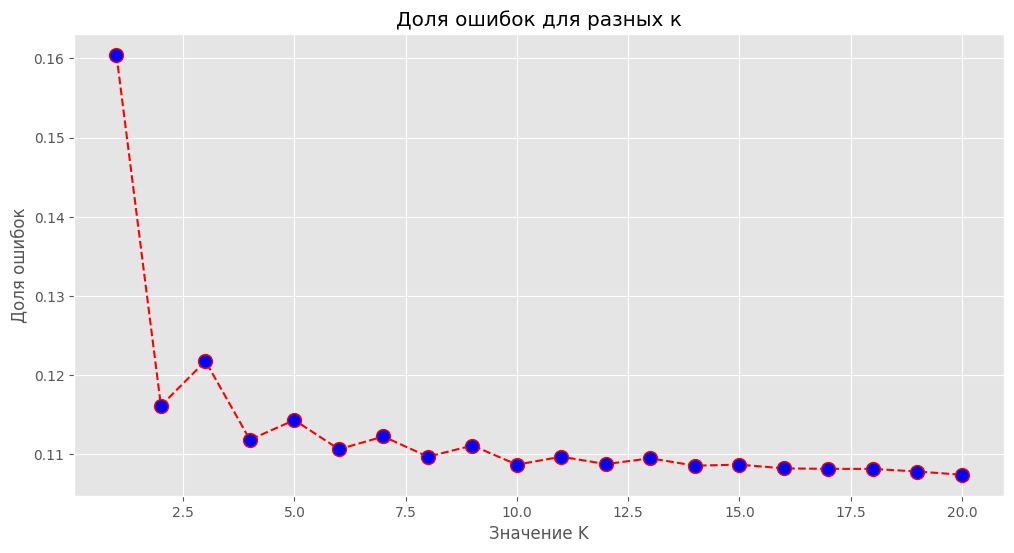

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(range(1, 21), error_rate, color='red', linestyle='dashed', marker='o',
         markerfacecolor='blue', markersize=10)

plt.title(u'Доля ошибок для разных к')
plt.xlabel(u'Значение K')
plt.ylabel(u'Доля ошибок')

Возьму к = 15

In [ ]:
#  построение классификатора

classifier = KNeighborsClassifier(n_neighbors = 15)
classifier.fit(X_train_2, y_train)


KNeighborsClassifier(n_neighbors = 15,
        algorithm='auto',
        leaf_size=30,
        metric='minkowski',
        p=2,                # так расст. Минковского  превращается в Евклидово
        metric_params=None,
        n_jobs=1,
        weights='uniform')

KNeighborsClassifier(n_jobs=1, n_neighbors=15)

In [ ]:
y_pred_train = classifier.predict(X_train_2)
y_pred_test = classifier.predict(X_test_2)

In [ ]:
print(u'Таблица сопряженности для обучающей выборки')
print(confusion_matrix(y_train, y_pred_train))
print('Accuracy на обучающей выборке', accuracy_score(y_train, y_pred_train, normalize=True))
print(classification_report(y_train, y_pred_train))

print(u'Таблица сопряженности для тестовой выборки')
print(confusion_matrix(y_test, y_pred_test))
print('Accuracy на тестовой выборке', accuracy_score(y_test, y_pred_test, normalize=True))
print(classification_report(y_test, y_pred_test))

Таблица сопряженности для обучающей выборки
[[26309   437]
 [ 2670   875]]
Accuracy на обучающей выборке 0.8974282790267736
              precision    recall  f1-score   support

           0       0.91      0.98      0.94     26746
           1       0.67      0.25      0.36      3545

    accuracy                           0.90     30291
   macro avg       0.79      0.62      0.65     30291
weighted avg       0.88      0.90      0.88     30291

Таблица сопряженности для тестовой выборки
[[12911   265]
 [ 1357   387]]
Accuracy на тестовой выборке 0.8912868632707774
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     13176
           1       0.59      0.22      0.32      1744

    accuracy                           0.89     14920
   macro avg       0.75      0.60      0.63     14920
weighted avg       0.87      0.89      0.87     14920



# K-fold cross-validation

In [ ]:
#  Число блоков  (folds)
n_folds = 5

kf = KFold(n_splits = n_folds, shuffle=True, random_state = 1234)


#  Варианты значений числа соседей
search_space = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

#  готовим список для хранения результатов подсчета accuracy,  избегаем использования append


accuracy_i = np.full((n_folds, len(search_space)), -9999.0)

fold_num = 0

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    #  стандартизация
    scaler = StandardScaler()   #   среднее 0, дисперсия 1
    scaler.fit(X_train)
    X_train_2 = scaler.transform(X_train)
    X_test_2  = scaler.transform(X_test)

    j_count = 0

    #  применяем KNN при разных K из search_space
    for j in search_space:
        knn_res = KNeighborsClassifier(n_neighbors=j)
        knn_res.fit(X_train_2, y_train)
        pred_i = knn_res.predict(X_test_2)
        #  сохраняем accuracy
        accuracy_i[fold_num, j_count ]= np.mean(pred_i == y_test)

        j_count = j_count +1

    fold_num = fold_num +1


print(accuracy_i)

[[0.83578458 0.88399867 0.88001769 0.88864315 0.8876479  0.8908548
  0.88952781 0.8915183  0.8915183  0.89118655 0.89019131 0.89284529
  0.89295588 0.89229238 0.89295588]
 [0.83344393 0.88099978 0.8738111  0.88608715 0.88420703 0.88852024
  0.88697191 0.88774607 0.88907321 0.89051095 0.88984738 0.89250166
  0.89139571 0.89084273 0.89084273]
 [0.84848485 0.88995797 0.88398584 0.89305463 0.89006857 0.89294404
  0.89239106 0.89515594 0.89327582 0.89515594 0.89349701 0.89548772
  0.89581951 0.89692546 0.89615129]
 [0.84195974 0.88608715 0.8782349  0.8892944  0.88896262 0.88984738
  0.89006857 0.89062154 0.89117452 0.89095333 0.8915063  0.89205928
  0.89228047 0.89205928 0.89216987]
 [0.84372926 0.88243751 0.87624419 0.88652953 0.88542358 0.88829905
  0.88829905 0.89062154 0.88907321 0.88973678 0.88863083 0.8892944
  0.88863083 0.88852024 0.88752488]]


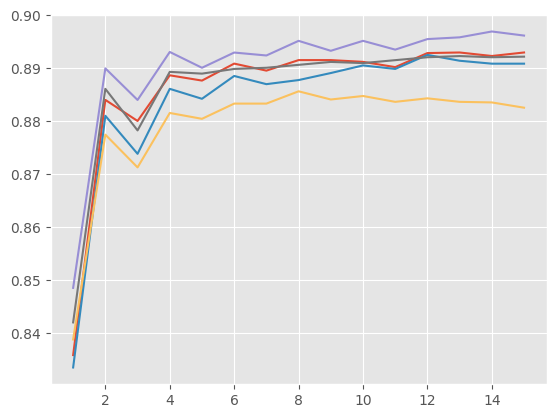

In [ ]:
plt.plot(list(range(1, 16)), accuracy_i[0, :])
plt.plot(list(range(1, 16)), accuracy_i[1, :])
plt.plot(list(range(1, 16)), accuracy_i[2, :])
plt.plot(list(range(1, 16)), accuracy_i[3, :])
plt.plot(list(range(1, 16)), accuracy_i[4, :]-0.005)

В данном случае я бы взяла число соседей, равное 8

In [ ]:
#  построение классификатора

classifier = KNeighborsClassifier(n_neighbors = 8)
classifier.fit(X_train_2, y_train)


KNeighborsClassifier(n_neighbors = 8,
        algorithm = 'auto',
        leaf_size = 30,
        metric='minkowski',
        p = 2,
        metric_params = None,
        n_jobs = 1,
        weights = 'uniform')

KNeighborsClassifier(n_jobs=1, n_neighbors=8)

In [ ]:
y_pred_train = classifier.predict(X_train_2)
y_pred_test = classifier.predict(X_test_2)

In [ ]:
print(u'Таблица сопряженности для обучающей выборки')
print(confusion_matrix(y_train, y_pred_train))
print('Accuracy на обучающей выборке', accuracy_score(y_train, y_pred_train, normalize=True))
print(classification_report(y_train, y_pred_train))

print(u'Таблица сопряженности для тестовой выборки')
print(confusion_matrix(y_test, y_pred_test))
print('Accuracy на тестовой выборке', accuracy_score(y_test, y_pred_test, normalize=True))
print(classification_report(y_test, y_pred_test))

Таблица сопряженности для обучающей выборки
[[31608   354]
 [ 3208   999]]
Accuracy на обучающей выборке 0.9015178744228483
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     31962
           1       0.74      0.24      0.36      4207

    accuracy                           0.90     36169
   macro avg       0.82      0.61      0.65     36169
weighted avg       0.89      0.90      0.88     36169

Таблица сопряженности для тестовой выборки
[[7830  130]
 [ 859  223]]
Accuracy на тестовой выборке 0.8906215439062154
              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7960
           1       0.63      0.21      0.31      1082

    accuracy                           0.89      9042
   macro avg       0.77      0.59      0.63      9042
weighted avg       0.87      0.89      0.87      9042



Таким образом, accuracy на обучающей выборке увеличилось на 1 %, на тестовой сильно ничего не поменялось